<font color=blue size=9> 3-layer neural network + Bach normalization </font>

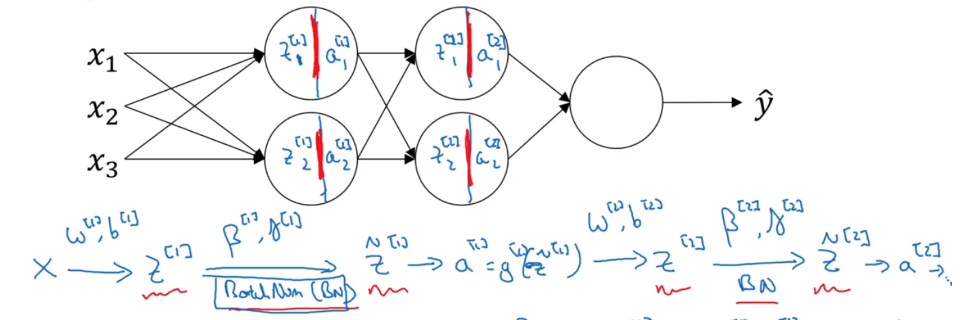
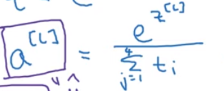

<font color=blue size=7> softmax cost function used in derivative </font>

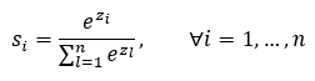
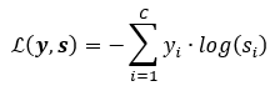
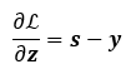


<font color=blue size=9> The batch normalization derivation </font>

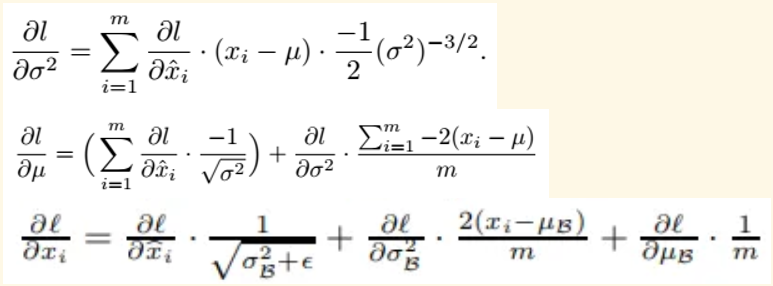

In [1]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))
        
        # Initialize batch normalization parameters
        self.gamma1 = np.ones((1, hidden_size))
        self.beta1 = np.zeros((1, hidden_size))
        self.gamma2 = np.ones((1, output_size))
        self.beta2 = np.zeros((1, output_size))
    
    def softmax(self, Z):
        # to check the exp_z....
        ## Get unnormalized probabilities
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        ## Normalize them for each sample
        A = exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
        return A
    
    def forward(self, X):
        # Input layer
        self.X = X
        
        # Hidden layer with batch normalization
        self.Z1 = np.dot(self.X, self.W1) + self.b1
        self.mean1 = np.mean(self.Z1, axis=0)
        self.var1 = np.var(self.Z1, axis=0)
        self.xmu = (self.Z1 - self.mean1)
        self.ivar = 1./np.sqrt(self.var1 + 1e-8)
        #print(self.ivar.shape)
        self.Z1_norm = (self.Z1 - self.mean1) / np.sqrt(self.var1 + 1e-8)
        self.Z1_bn = self.gamma1 * self.Z1_norm + self.beta1
        # ReLU activation
        self.A1 = np.maximum(0, self.Z1_bn) 
        
        # Output layer with batch normalization
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.mean2 = np.mean(self.Z2, axis=0)
        self.var2 = np.var(self.Z2, axis=0)
        self.Z2_norm = (self.Z2 - self.mean2) / np.sqrt(self.var2 + 1e-8)
        self.Z2_bn = self.gamma2 * self.Z2_norm + self.beta2
        # softwmax activation
        self.A2 = self.softmax(self.Z2_bn)
        
        return self.A2
    
    def backward(self, y):
        # Output layer
        #bach normliazation derivative
        self.dZ2_bn = self.A2 - y
        self.dgamma2 = np.sum(self.dZ2_bn * self.Z2_norm, axis=0)
        self.dbeta2 = np.sum(self.dZ2_bn, axis=0)
        self.dZ2_norm = self.dZ2_bn * self.gamma2
        self.dZ2 = (self.dZ2_norm / np.sqrt(self.var2 + 1e-8)) + \
                   ((self.Z2 - self.mean2) * np.sum(self.dZ2_norm * (self.Z2 - self.mean2), axis=0) / \
                   ((self.var2 + 1e-8) * self.hidden_size * np.sqrt(self.var2 + 1e-8)))
        self.dW2 = np.dot(self.A1.T, self.dZ2)
        self.db2 = np.sum(self.dZ2, axis=0)
        

        # Hidden layer
        # bach normliazation derivative
        self.dZ1_bn = np.dot(self.dZ2, self.W2.T)
        self.dgamma1 = np.sum(self.dZ1_bn * self.Z1_norm, axis=0)
        self.dbeta1 = np.sum(self.dZ1_bn, axis=0)
        self.dZ1_norm = self.dZ1_bn * self.gamma1
        #print(self.dZ1_norm.shape) #(32,10)

        #way 1, using offical derivative equation -- works
        self.dvar1 = np.sum(self.dZ1_norm*(self.xmu)*(-0.5)*(self.var1 + 1e-8)**(-1.5), axis=0)
        self.dmu  = np.sum(self.dZ1_norm*(-1/np.sqrt(self.var1 + 1e-8)), axis=0) + self.dvar1* np.mean(-2*(self.Z1 - self.mean1), axis=0)
        self.dZ1 = self.dZ1_norm*(1/np.sqrt(self.var1 + 1e-8)) + self.dvar1*2*(self.Z1 - self.mean1)/y.shape[0] + self.dmu/y.shape[0]           
        
        #way 2 using the compute grapth derivative equation --- don't work.
        #get dxmu1 and divar
        self.dxmu1 = self.dZ1_norm * self.ivar        
        self.divar = np.sum(self.dZ1_norm*self.xmu, axis=0)
        #print(self.divar.shape) #(10,)
        #get dsqrtvar
        self.dsqrtvar = -1. /(self.var1 + 1e-8) * self.divar
        self.dvar1 = 0.5 * 1. /np.sqrt(self.var1 + 1e-8) * self.dsqrtvar
        #print(self.dvar1.shape) #(10,)

        #step4
        #self.dsq = 1. /self.hidden_size * np.ones((y.shape[0],self.hidden_size)) * self.dvar1
        #step3
        #self.dxmu2 = 2 * self.xmu * self.dsq
        #step2
        #self.dz1 = (self.dxmu1 + self.dxmu2)
        #self.dmu = -1 * np.sum(self.dxmu1+self.dxmu2, axis=0)
        
        #print(self.dmu.shape)
        #step1
        #self.dz2 = 1. /self.input_size * np.ones((self.input_size,y.shape[0])) * self.dmu
        #step0
        #self.dZ1 = self.dz1 + self.dz2

        #way 3 using the overall eqution for dZ --- works
        #self.dZ1 = (self.dZ1_norm / np.sqrt(self.var1 + 1e-8)) + \
        #           ((self.Z1 - self.mean1) * np.sum(self.dZ1_norm * (self.Z1 - self.mean1), axis=0) / \
        #           ((self.var1 + 1e-8) * self.input_size * np.sqrt(self.var1 + 1e-8)))
        #print(self.dZ1.shape) #(32,10)
        self.dW1 = np.dot(self.X.T, self.dZ1)
        self.db1 = np.sum(self.dZ1, axis=0)
          
    def batch_norm_deriv(dout, cache):
        x, x_norm, mu, var, gamma, beta, eps = cache
        N, D = x.shape
        dbeta = np.sum(dout, axis=0)
        dgamma = np.sum(dout*x_norm, axis=0)
        dx_norm = dout*gamma
        dvar = np.sum(dx_norm*(x - mu)*(-0.5)*(var + eps)**(-1.5), axis=0)
        dmu = np.sum(dx_norm*(-1/np.sqrt(var + eps)), axis=0) + dvar*np.mean(-2*(x - mu), axis=0)
        dx = dx_norm*(1/np.sqrt(var + eps)) + dvar*2*(x - mu)/N + dmu/N
        return dx, dgamma, dbeta
    

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the neural network
nn = NeuralNetwork(input_size=X.shape[1], hidden_size=10, output_size=y.shape[1], learning_rate=0.01)

# Train the neural network
for i in range(5000):
    # Select a random batch of samples
    indices = np.random.randint(low=0, high=len(X_train), size=32)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    
    # Forward pass
    A2 = nn.forward(X_batch)
    
    # Compute the loss
    loss = -np.sum(y_batch * np.log(A2 + 1e-8)) / len(X_batch)
    
    # Backward pass
    nn.backward(y_batch)
    
    # Update the weights and biases
    nn.W1 -= nn.learning_rate * nn.dW1
    nn.b1 -= nn.learning_rate * nn.db1
    nn.W2 -= nn.learning_rate * nn.dW2
    nn.b2 -= nn.learning_rate * nn.db2
    nn.gamma1 -= nn.learning_rate * nn.dgamma1
    nn.beta1 -= nn.learning_rate * nn.dbeta1
    nn.gamma2 -= nn.learning_rate * nn.dgamma2
    nn.beta2 -= nn.learning_rate * nn.dbeta2
    
    # Print the loss every 100 epochs
    if i % 100 == 0:
        print(f"Epoch {i}: Loss = {loss}")
        
# Evaluate the neural network on the test set
A2_test = nn.forward(X_test)
predictions = np.argmax(A2_test, axis=1)
labels = np.argmax(y_test, axis=1)
accuracy = np.sum(predictions == labels) / len(X_test)
print(f"Test Accuracy = {accuracy}")

Epoch 0: Loss = 0.6576256040253938
Epoch 100: Loss = 0.25714544583485127
Epoch 200: Loss = 0.16041557782554108
Epoch 300: Loss = 0.1420440748904043
Epoch 400: Loss = 0.09293637704519456
Epoch 500: Loss = 0.12358822194330613
Epoch 600: Loss = 0.13623649653288142
Epoch 700: Loss = 0.15276536161905893
Epoch 800: Loss = 0.12926809262120711
Epoch 900: Loss = 0.12964797324971483
Epoch 1000: Loss = 0.10150174087792321
Epoch 1100: Loss = 0.09607673713666152
Epoch 1200: Loss = 0.06882240165330336
Epoch 1300: Loss = 0.09911857148858524
Epoch 1400: Loss = 0.11546538878925913
Epoch 1500: Loss = 0.08167157223756522
Epoch 1600: Loss = 0.10773633558312429
Epoch 1700: Loss = 0.07622238345343946
Epoch 1800: Loss = 0.07987081118003263
Epoch 1900: Loss = 0.2952724436978832
Epoch 2000: Loss = 0.10060415992797508
Epoch 2100: Loss = 0.11463342869130896
Epoch 2200: Loss = 0.15120585644481926
Epoch 2300: Loss = 0.17890660847716625
Epoch 2400: Loss = 0.06876553279272897
Epoch 2500: Loss = 0.04300248501771808
E

In [3]:
y_batch.shape[0]

32